## <b>3.3 PREPROCESSAMENT I ANÀLISI DE DADES</b>

### <b>3.3.3 Anàlisi exploratòria de dades (EDA)</b>

#### <b>3.3.3.1 Preparació i definició de variables</b>

In [4]:
# ============================================================
# 3.3.3 ANÀLISI EXPLORATÒRIA DE DADES (EDA)
# ============================================================
# Nota important per coherència metodològica:
# - En aquesta EDA puc mirar variables "ex post" (costos, ràtios, etc.)
#   com a eina de diagnòstic i comprensió del dataset,
#   però NO les consideraré predictors dels models de freqüència o severitat.
# - La divisió temporal que faig servir aquí (set_type) és exactament la mateixa
#   que utilitzaré després en la modelització:
#       train: 2015–2017   |   test: 2018
# ============================================================


# ============================================================
# 3.3.3.1 PREPARACIÓ I DEFINICIÓ DE VARIABLES (EDA)
# ============================================================
import pandas as pd
import numpy as np

# Ajusto opcions de visualització perquè les taules es vegin millor a l'EDA
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# ------------------------------------------------------------
# 1) CÀRREGA DEL DATASET FINAL PER A L'EDA
# ------------------------------------------------------------
# Per defecte treballo amb el fitxer canònic del pipeline,
# que manté els decimals amb punt (format intern de càlcul).
# Si volgués analitzar la versió amb format europeu, només caldria canviar aquest path.
path_eda = "transformed_motor_insurance.csv"

df = pd.read_csv(path_eda, sep=",", encoding="utf-8")

print("Dataset EDA carregat correctament")
print("Fitxer:", path_eda)
print("Dimensions (files, columnes):", df.shape)

# Mostro una primera ullada ràpida per verificar que tot ha carregat bé
print("\nPrimeres 5 files:")
display(df.head())

# ------------------------------------------------------------
# 2) TIPUS DE DADES I CONVERSIONS LLEUGERES
#    (sense modificar el dataset de fons)
# ------------------------------------------------------------
# Aquí reviso els tipus de dades i faig només conversions suaus,
# pensades exclusivament per facilitar l'EDA (no altero el pipeline).
print("\n--- Tipus de dades inicials (dtypes) ---")
display(df.dtypes)

# Converteixo a datetime només les columnes de data que faré servir
# per anàlisi temporal a l'EDA.
date_cols = [
    "Date_start_contract", "Date_last_renewal", "Date_next_renewal",
    "Date_birth", "Date_driving_licence", "Date_lapse"
]
# Em quedo només amb les que realment existeixen al dataset
date_cols = [c for c in date_cols if c in df.columns]

for c in date_cols:
    # Converteixo de manera tolerant: valors problemàtics passen a NaT
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Conversions numèriques "suaus":
# Si una columna és object però en realitat conté números,
# intento convertir-la, però només si la gran majoria de valors són numèrics.
# Així evito convertir categories textuals per error.
for c in df.columns:
    if df[c].dtype == "object":
        tmp = pd.to_numeric(df[c], errors="coerce")
        if tmp.notna().mean() > 0.90:  # criteri conservador
            df[c] = tmp

print("\n--- Tipus després de conversions suaus ---")
display(df.dtypes)

# ------------------------------------------------------------
# 3) TAULA DE NULS (QUALITAT DE DADES)
# ------------------------------------------------------------
# Analitzo la presència de valors nuls per entendre la qualitat
# i recordar quins nuls són estructurals.
missing_count = df.isna().sum()
missing_pct = (missing_count / len(df) * 100).round(2)

missing_table = (
    pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
    .sort_values("missing_count", ascending=False)
)

print("\n--- Taula de valors nuls (top 15) ---")
display(missing_table.head(15))

print("\nVariables amb >10% de nuls:")
display(missing_table[missing_table["missing_pct"] > 10])

# ------------------------------------------------------------
# 4) VARIABLE TEMPORAL + SPLIT COHERENT AMB MODELITZACIÓ
# ------------------------------------------------------------
# Derivo l'any de pòlissa a partir de Date_last_renewal,
# que és la referència temporal coherent amb el negoci.
if "Date_last_renewal" not in df.columns:
    raise ValueError("No existeix Date_last_renewal al dataset. No es pot derivar Policy_year.")

df["Policy_year"] = df["Date_last_renewal"].dt.year

# Elimino registres sense any de pòlissa (no els puc usar temporalment)
df = df.dropna(subset=["Policy_year"]).copy()
df["Policy_year"] = df["Policy_year"].astype(int)

# Creo el split temporal coherent amb la validació final dels models
df["set_type"] = np.where(df["Policy_year"] < 2018, "train", "test")

print("\n--- Distribució per any (Policy_year) ---")
display(df["Policy_year"].value_counts().sort_index())

print("\n--- Distribució train/test (set_type) ---")
display(df["set_type"].value_counts())

print("\n--- Taula per any i set_type ---")
display(df.groupby(["Policy_year", "set_type"]).size())

# ------------------------------------------------------------
# 5) MAPA DE VARIABLES PER MODEL (SENSE LEAKAGE)
# ------------------------------------------------------------
# Defineixo explícitament quines variables considero predictors ex ante,
# separant freqüència i severitat, i evitant qualsevol leakage.

# Predictors ex ante per a FREQÜÈNCIA
freq_features = [
    "Driver_age", "Licence_age", "Vehicle_age", "Has_lapse", "Policy_duration",
    "Second_driver", "Area", "Type_risk", "Type_fuel", "Has_claims_history",
    "Value_vehicle", "Power", "Premium", "Seniority", "Policies_in_force",
    "Distribution_channel"
]

# Predictors ex ante per a SEVERITAT (condicionat a sinistre)
sev_features = [
    "Vehicle_age", "Value_vehicle", "Power", "Type_risk", "Area", "Policy_duration",
    "Weight", "Cylinder_capacity", "Premium", "Length"
]

# Variables objectiu (targets)
targets = ["Has_claims_year", "Cost_claims_year"]

# Variables econòmiques que només faig servir com a diagnòstic
# (NO entren com a predictors dels models)
econ_diagnostic = ["Claims_to_premium_ratio"]

# Flags de qualitat i traçabilitat (només els que realment existeixin)
flags_features = [
    "Licence_incoherent_flag",
    "Policy_incoherent_flag",
    "Lapse_incoherent_flag",
    "Length_missing_flag"
]

print("\n--- Mapa de variables segons model (coherent amb l'enginyeria posterior) ---")
print("Freq predictors (ex ante):", freq_features)
print("\nSev predictors (ex ante):", sev_features)
print("\nTargets:", targets)
print("\nVariables econòmiques diagnòstic:", econ_diagnostic)
print("\nFlags qualitat:", flags_features)

# Valido que totes les columnes clau existeixen al dataset
expected_cols = set(
    freq_features
    + sev_features
    + targets
    + econ_diagnostic
    + flags_features
    + ["ID", "Policy_year", "set_type"]
)

missing_expected = expected_cols - set(df.columns)

if missing_expected:
    print("\nVariables esperades però NO trobades al dataset:")
    print(missing_expected)
else:
    print("\nTotes les variables clau són presents al dataset.")

# ------------------------------------------------------------
# 6) COMPROVACIONS RÀPIDES DE TARGETS I FLAGS (GLOBAL)
# ------------------------------------------------------------
# Reviso distribucions bàsiques per assegurar-me que tot té sentit
# abans d'entrar en gràfics o anàlisis més detallades.

if "Has_claims_year" in df.columns:
    print("\n--- Distribució Has_claims_year ---")
    display(df["Has_claims_year"].value_counts(dropna=False))

if "Has_claims_history" in df.columns:
    print("\n--- Distribució Has_claims_history ---")
    display(df["Has_claims_history"].value_counts(dropna=False))

if "Has_lapse" in df.columns:
    print("\n--- Distribució Has_lapse ---")
    display(df["Has_lapse"].value_counts(dropna=False))

flags_exist = [c for c in flags_features if c in df.columns]
if flags_exist:
    print("\n--- Flags (suma de casos marcats) ---")
    display(df[flags_exist].sum())

# Tanco aquest subapartat amb un petit resum executiu
print("\n--- RESUM EXECUTIU 3.3.3.1 ---")
print(f"Registres: {df.shape[0]:,}")
print(f"Variables: {df.shape[1]}")
print("\nDataset preparat per continuar amb 3.3.3.2")


Dataset EDA carregat correctament
Fitxer: transformed_motor_insurance.csv
Dimensions (files, columnes): (105555, 44)

Primeres 5 files:


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Date_lapse,Driver_age,Licence_age,Vehicle_age,Policy_age,Days_to_next,Policy_duration,Has_lapse,Licence_incoherent_flag,Policy_incoherent_flag,Lapse_incoherent_flag,Length_missing_flag,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Type_risk,Area,Second_driver,Premium,N_claims_year,Cost_claims_year,N_claims_history,R_Claims_history,Has_claims_year,Has_claims_history,Claims_to_premium_ratio,Payment,Lapse,Type_fuel
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,NaN,59.556468,39.627652,11,0.000000,366,NaN,0,0,0,0,1,2004,80,599,7068.0,0,3.343,190,0,4,1,2,1,1,0,0,222.52,0,0.0,0,0.0,0,0,0.0,0,0,P
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,NaN,59.556468,40.629706,11,1.002053,365,NaN,0,0,0,0,1,2004,80,599,7068.0,0,3.343,190,0,4,1,2,1,1,0,0,213.78,0,0.0,0,0.0,0,0,0.0,0,0,P
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,NaN,59.556468,41.629021,11,2.001369,365,NaN,0,0,0,0,1,2004,80,599,7068.0,0,3.343,190,0,4,2,2,1,1,0,0,214.84,0,0.0,0,0.0,0,0,0.0,0,0,P
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,NaN,59.556468,42.628337,11,3.000684,365,NaN,0,0,0,0,1,2004,80,599,7068.0,0,3.343,190,0,4,2,2,1,1,0,0,216.99,0,0.0,0,0.0,0,0,0.0,0,0,P
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,NaN,61.448323,41.519507,13,0.000000,365,NaN,0,0,0,0,1,2004,80,599,7068.0,0,3.343,190,0,4,2,2,1,1,0,0,213.70,0,0.0,0,0.0,0,0,0.0,1,0,P



--- Tipus de dades inicials (dtypes) ---


ID                           int64
Date_start_contract         object
Date_last_renewal           object
Date_next_renewal           object
Date_birth                  object
Date_driving_licence        object
Date_lapse                  object
Driver_age                 float64
Licence_age                float64
Vehicle_age                  int64
Policy_age                 float64
Days_to_next                 int64
Policy_duration            float64
Has_lapse                    int64
Licence_incoherent_flag      int64
Policy_incoherent_flag       int64
Lapse_incoherent_flag        int64
Length_missing_flag          int64
Year_matriculation           int64
Power                        int64
Cylinder_capacity            int64
Value_vehicle              float64
N_doors                      int64
Length                     float64
Weight                       int64
Distribution_channel         int64
Seniority                    int64
Policies_in_force            int64
Max_policies        


--- Tipus després de conversions suaus ---


ID                                  int64
Date_start_contract        datetime64[ns]
Date_last_renewal          datetime64[ns]
Date_next_renewal          datetime64[ns]
Date_birth                 datetime64[ns]
Date_driving_licence       datetime64[ns]
Date_lapse                 datetime64[ns]
Driver_age                        float64
Licence_age                       float64
Vehicle_age                         int64
Policy_age                        float64
Days_to_next                        int64
Policy_duration                   float64
Has_lapse                           int64
Licence_incoherent_flag             int64
Policy_incoherent_flag              int64
Lapse_incoherent_flag               int64
Length_missing_flag                 int64
Year_matriculation                  int64
Power                               int64
Cylinder_capacity                   int64
Value_vehicle                     float64
N_doors                             int64
Length                            


--- Taula de valors nuls (top 15) ---


,missing_count,missing_pct
Policy_duration,70408,66.7
Date_lapse,70408,66.7
ID,0,0.0
Distribution_channel,0,0.0
Seniority,0,0.0
Policies_in_force,0,0.0
Max_policies,0,0.0
Max_products,0,0.0
Type_risk,0,0.0
Area,0,0.0



Variables amb >10% de nuls:


,missing_count,missing_pct
Policy_duration,70408,66.7
Date_lapse,70408,66.7



--- Distribució per any (Policy_year) ---


Policy_year
2015     4559
2016    31428
2017    33753
2018    35815
Name: count, dtype: int64


--- Distribució train/test (set_type) ---


set_type
train    69740
test     35815
Name: count, dtype: int64


--- Taula per any i set_type ---


Policy_year  set_type
2015         train        4559
2016         train       31428
2017         train       33753
2018         test        35815
dtype: int64


--- Mapa de variables segons model (coherent amb l'enginyeria posterior) ---
Freq predictors (ex ante): ['Driver_age', 'Licence_age', 'Vehicle_age', 'Has_lapse', 'Policy_duration', 'Second_driver', 'Area', 'Type_risk', 'Type_fuel', 'Has_claims_history', 'Value_vehicle', 'Power', 'Premium', 'Seniority', 'Policies_in_force', 'Distribution_channel']

Sev predictors (ex ante): ['Vehicle_age', 'Value_vehicle', 'Power', 'Type_risk', 'Area', 'Policy_duration', 'Weight', 'Cylinder_capacity', 'Premium', 'Length']

Targets: ['Has_claims_year', 'Cost_claims_year']

Variables econòmiques diagnòstic: ['Claims_to_premium_ratio']

Flags qualitat: ['Licence_incoherent_flag', 'Policy_incoherent_flag', 'Lapse_incoherent_flag', 'Length_missing_flag']

Totes les variables clau són presents al dataset.

--- Distribució Has_claims_year ---


Has_claims_year
0    85909
1    19646
Name: count, dtype: int64


--- Distribució Has_claims_history ---


Has_claims_history
1    68959
0    36596
Name: count, dtype: int64


--- Distribució Has_lapse ---


Has_lapse
0    70408
1    35147
Name: count, dtype: int64


--- Flags (suma de casos marcats) ---


Licence_incoherent_flag       31
Policy_incoherent_flag        68
Lapse_incoherent_flag        404
Length_missing_flag        10329
dtype: int64


--- RESUM EXECUTIU 3.3.3.1 ---
Registres: 105,555
Variables: 46

Dataset preparat per continuar amb 3.3.3.2


#### <b>3.3.3.2 Anàlisi descriptiva general</b>

Dataset disponible per a 3.3.3.2
Dimensions: (105555, 46)

--- Estadístiques descriptives numèriques ---


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,missing_pct
Driver_age,105555.0,44.344252,12.765230,18.015058,20.394251,24.810404,34.234086,43.972621,53.733060,66.543463,72.936345,91.529090,0.0
Licence_age,105555.0,24.765647,12.485724,0.000000,1.886379,6.745243,14.410678,23.854894,34.171116,46.394524,53.017002,74.028747,0.0
Vehicle_age,105555.0,9.244887,7.148871,0.000000,0.000000,0.000000,4.000000,9.000000,13.000000,20.000000,33.000000,68.000000,0.0
Policy_age,105555.0,2.981514,3.923288,0.000000,0.000000,0.000000,0.000000,1.002053,4.000000,11.000684,17.998631,37.998631,0.0
Days_to_next,105555.0,365.088020,0.283326,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,366.000000,366.000000,366.000000,0.0
Policy_duration,35147.0,3.498137,3.477066,0.010000,0.500000,1.000000,1.000000,2.000000,4.000000,11.000000,17.340000,30.000000,66.7
Has_lapse,105555.0,0.332973,0.471279,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0
Licence_incoherent_flag,105555.0,0.000294,0.017135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
Policy_incoherent_flag,105555.0,0.000644,0.025373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
Lapse_incoherent_flag,105555.0,0.003827,0.061748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0


Figura desada a: eda/figures\hist_top_numeric.png


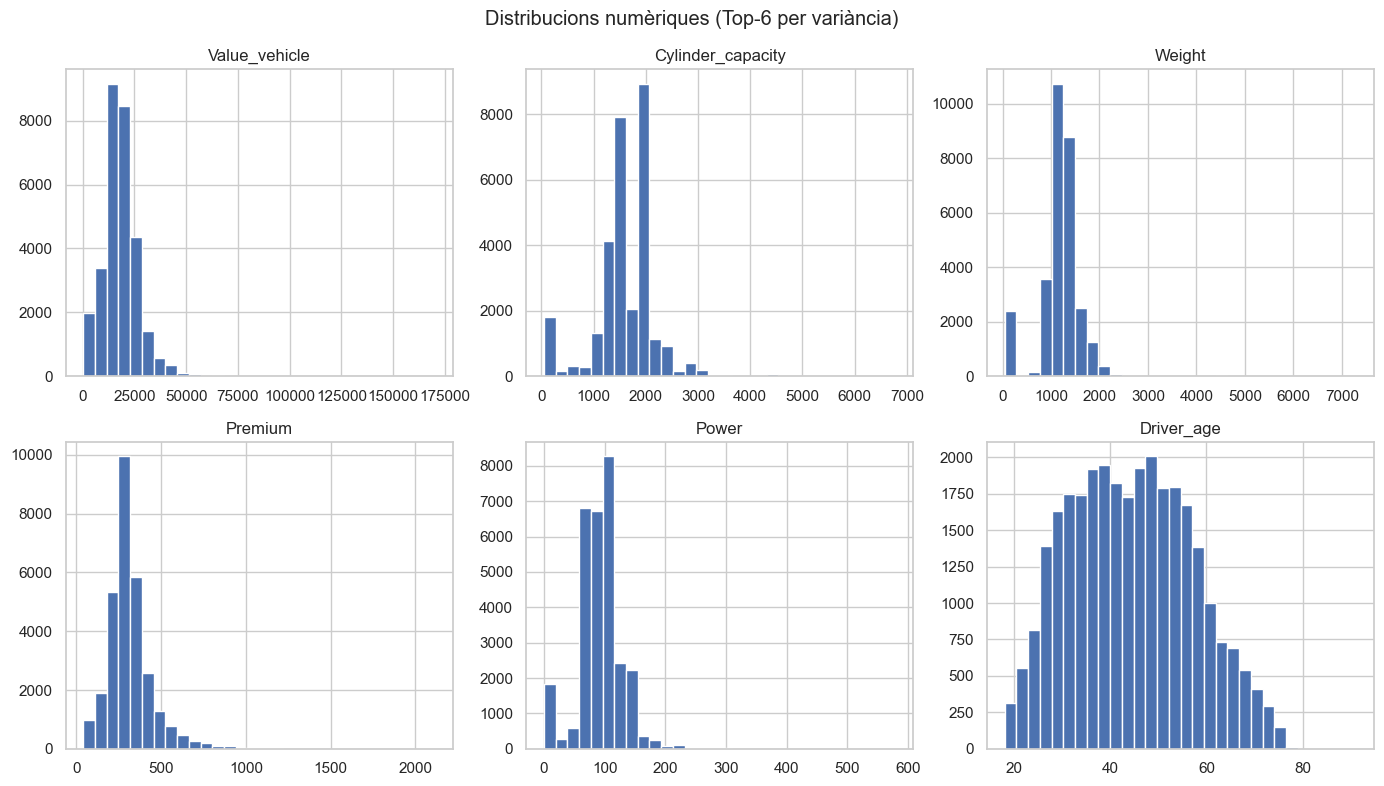


>>> Distribució de Type_risk


,count,pct
Type_risk,,
3,82990,78.62
2,13212,12.52
1,8502,8.05
4,851,0.81


Figura desada a: eda/figures\dist_Type_risk.png


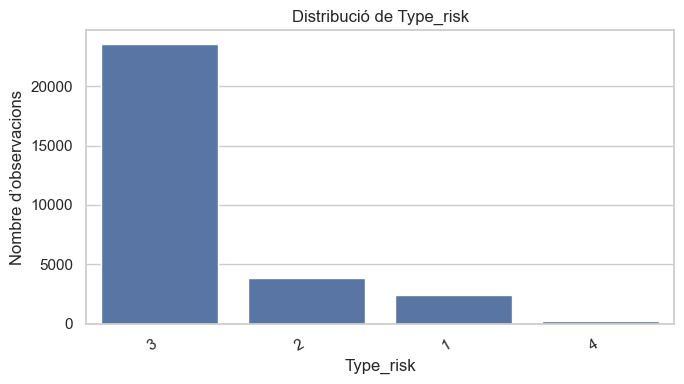


>>> Distribució de Area


,count,pct
Area,,
0,76644,72.61
1,28911,27.39


Figura desada a: eda/figures\dist_Area.png


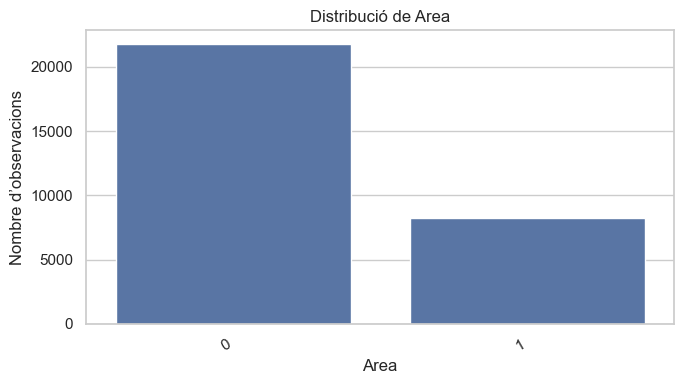


>>> Distribució de Distribution_channel


,count,pct
Distribution_channel,,
0,57917,54.87
1,47638,45.13


Figura desada a: eda/figures\dist_Distribution_channel.png


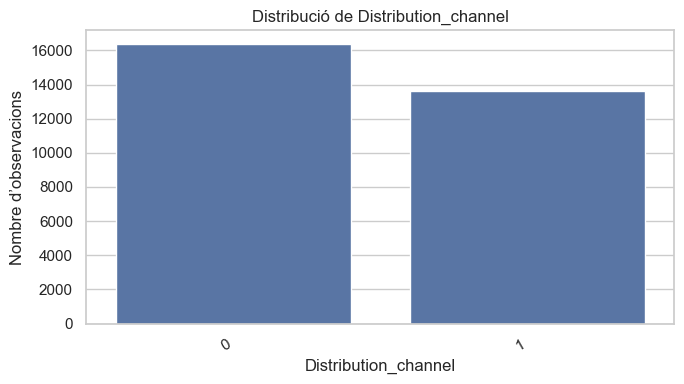


>>> Distribució de Type_fuel


,count,pct
Type_fuel,,
D,64998,61.58
P,38793,36.75
Unknown,1764,1.67


Figura desada a: eda/figures\dist_Type_fuel.png


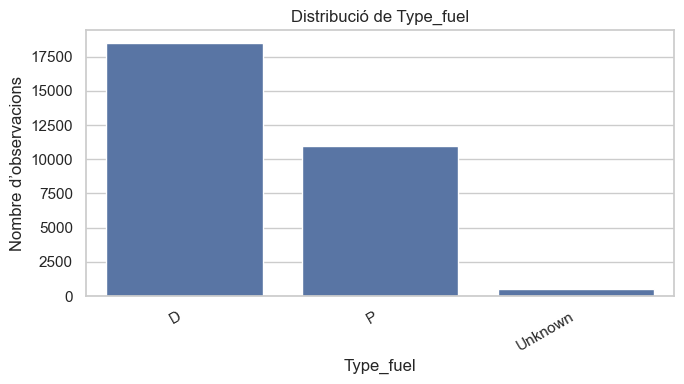


>>> Distribució de Second_driver


,count,pct
Second_driver,,
0,92497,87.63
1,13058,12.37


Figura desada a: eda/figures\dist_Second_driver.png


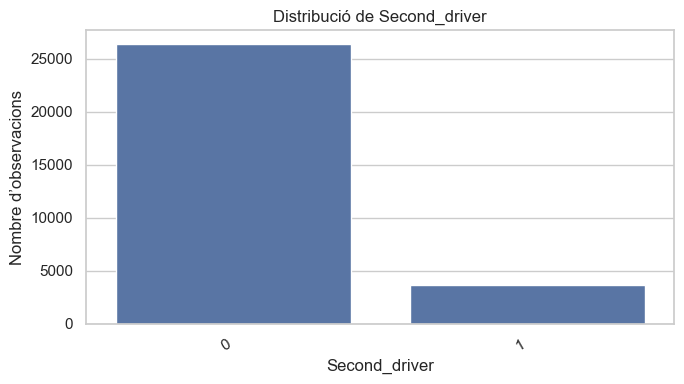


>>> Distribució de Has_lapse


,count,pct
Has_lapse,,
0,70408,66.7
1,35147,33.3


Figura desada a: eda/figures\dist_Has_lapse.png


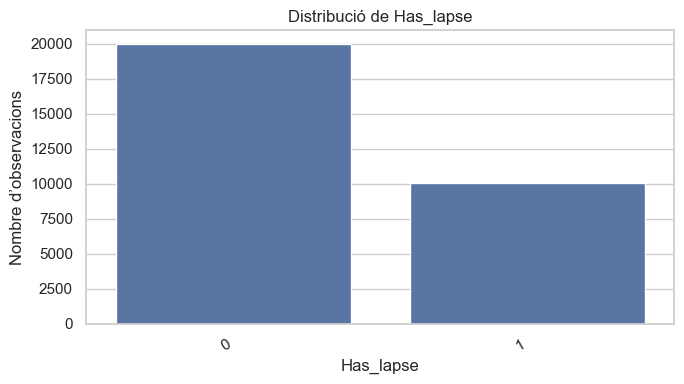


--- Diferències de mitjana per Has_claims_year ---


Has_claims_year,0,1,diff_1_minus_0
Value_vehicle,18097.780615,19794.938179,1697.157564
Cylinder_capacity,1594.606328,1719.004123,124.397795
Weight,1175.109069,1261.898605,86.789536
Premium,308.762478,347.071319,38.308841
Power,91.305416,98.704876,7.399460
N_claims_history,2.213715,5.104551,2.890836
Claims_to_premium_ratio,0.000000,2.558401,2.558401
N_claims_year,0.000000,2.120635,2.120635
R_Claims_history,0.228294,1.286210,1.057916
Vehicle_age,9.134701,9.726713,0.592012


Figura desada a: eda/figures\scatter_Value_vehicle_vs_Premium.png


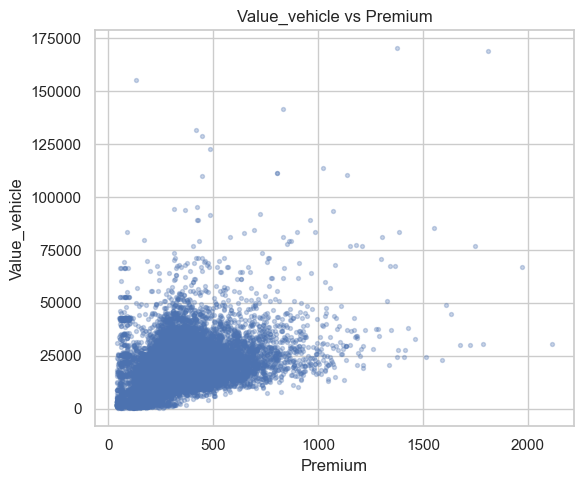

Figura desada a: eda/figures\scatter_Value_vehicle_vs_Vehicle_age.png


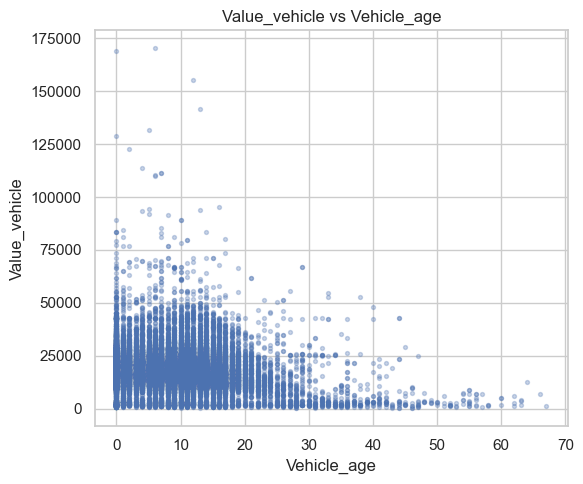


--- Resum d’outliers (IQR i z-score) ---


,iqr_outliers_pct,z_gt3_pct
variable,,
Power,9.18,0.78
Premium,6.99,1.63
Value_vehicle,3.17,1.09
Length,2.16,1.15
Vehicle_age,2.01,1.32
Claims_to_premium_ratio,0.00,0.45
Cost_claims_year,0.00,0.47
Driver_age,0.00,0.01


Figura desada a: eda/figures\boxplot_Claims_to_premium_ratio.png


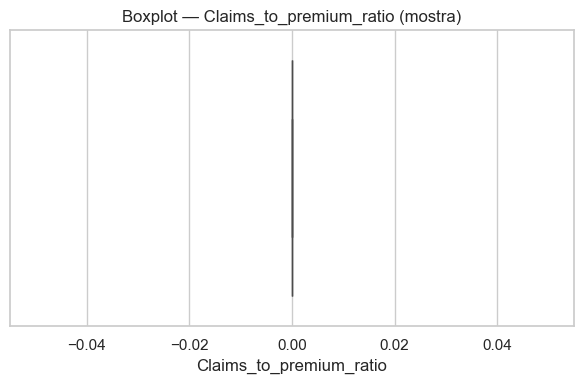

Figura desada a: eda/figures\boxplot_Cost_claims_year.png


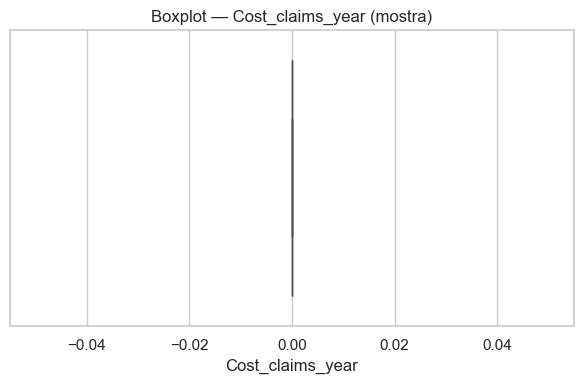

Figura desada a: eda/figures\boxplot_Driver_age.png


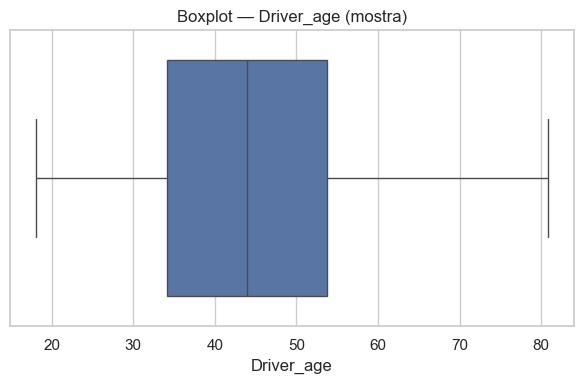

Figura desada a: eda/figures\boxplot_Length.png


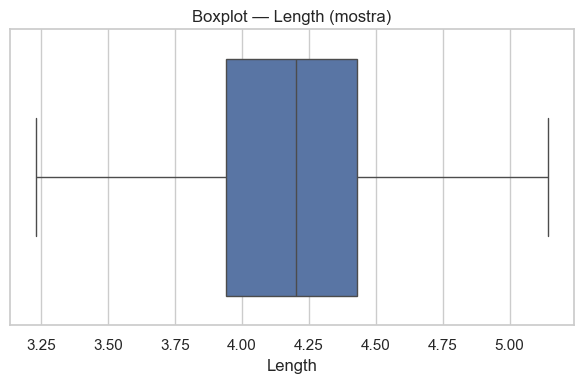

Figura desada a: eda/figures\boxplot_Power.png


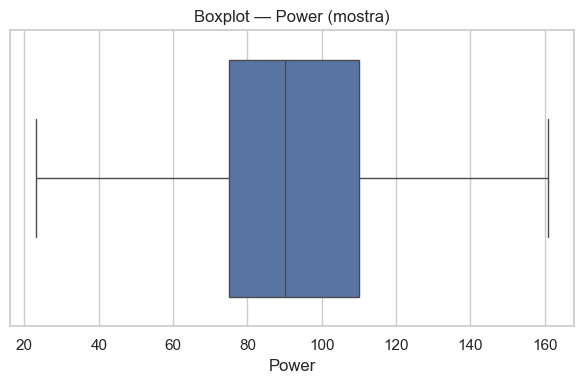

Figura desada a: eda/figures\boxplot_Premium.png


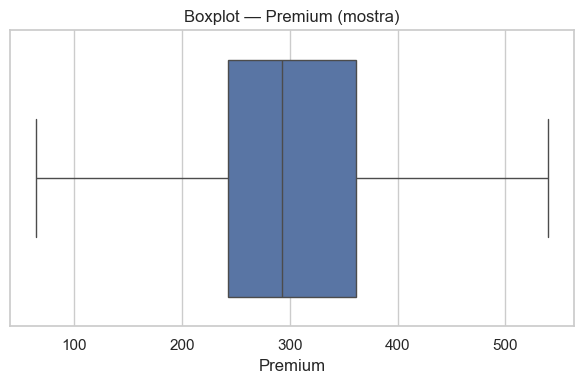

Figura desada a: eda/figures\boxplot_Value_vehicle.png


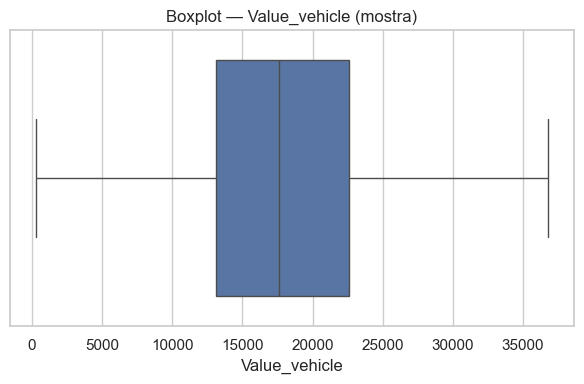

Figura desada a: eda/figures\boxplot_Vehicle_age.png


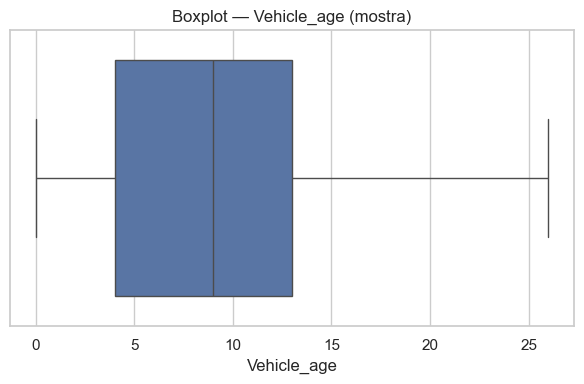

Figura desada a: eda/figures\eda_corr_matrix.png


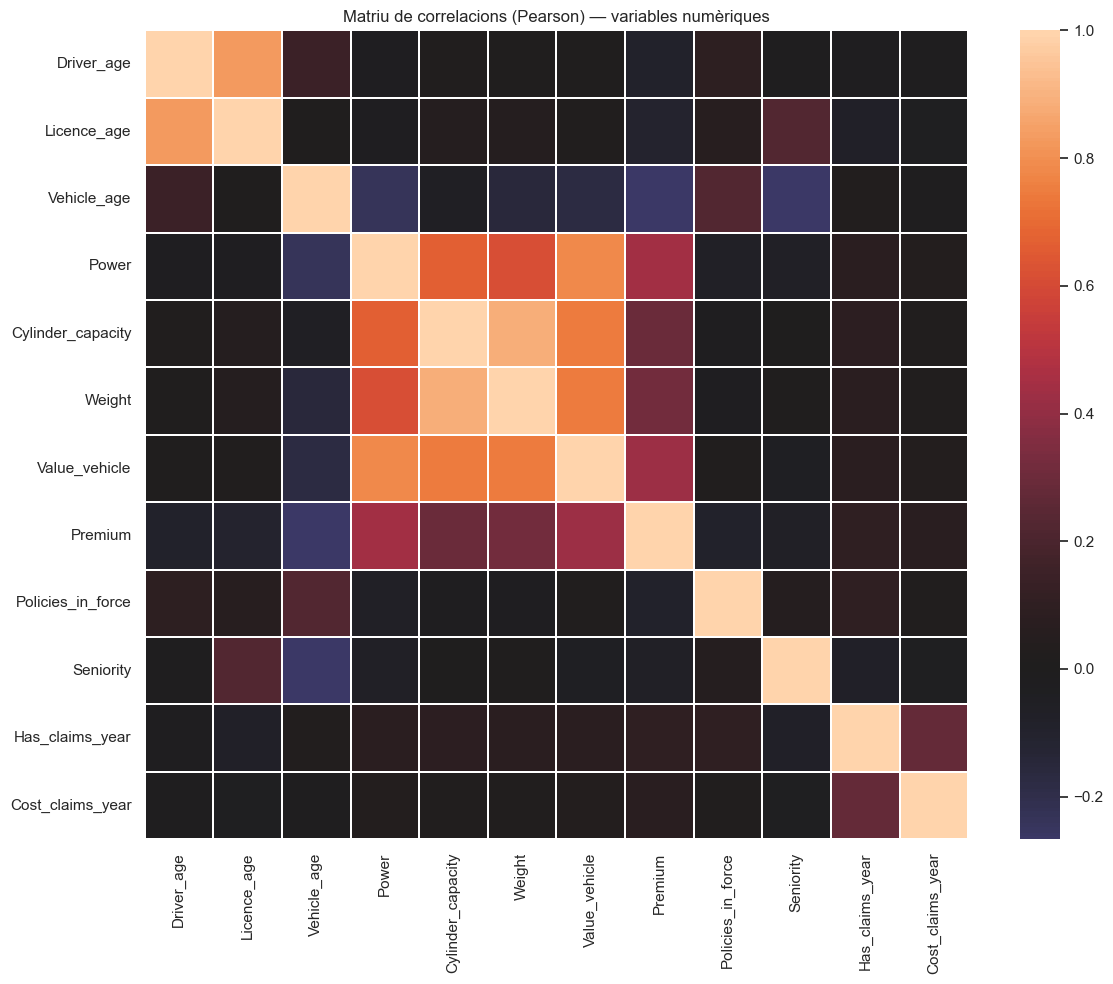


--- SÍNTESI EXECUTIVA 3.3.3.2 ---
Variables numèriques analitzades: 35
Variables categòriques analitzades: 6

Top-5 variables amb més outliers (IQR):


,iqr_outliers_pct,z_gt3_pct
variable,,
Power,9.18,0.78
Premium,6.99,1.63
Value_vehicle,3.17,1.09
Length,2.16,1.15
Vehicle_age,2.01,1.32



3.3.3.2 COMPLET. Revisar la carpeta 'eda/figures' per a les figures.


In [7]:
# ============================================================
# 3.3.3.2 ANÀLISI DESCRIPTIVA GENERAL (EDA)
# ============================================================
# Objectius d’aquest bloc:
#   - Calcular estadístiques descriptives de les variables numèriques
#   - Analitzar distribucions de variables categòriques rellevants
#   - Explorar relacions bàsiques amb la freqüència de sinistre
#   - Fer un diagnòstic preliminar d’outliers
#   - Analitzar correlacions globals entre variables numèriques
#
# Premisses que tinc en compte:
#   * El dataset `df` ja està carregat, net i preparat al punt 3.3.3.1
#   * Aquesta EDA és purament descriptiva (NO faig selecció de variables)
#   * Per als gràfics utilitzo mostreig per millorar rendiment i llegibilitat
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració visual per tenir gràfics i taules clares
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# 0) PREPARACIÓ GENERAL
# ------------------------------------------------------------

# Creo (si no existeix) la carpeta on guardaré totes les figures de l'EDA
os.makedirs("eda/figures", exist_ok=True)

def savefig_eda(filename, dpi=150):
    """
    Funció auxiliar per desar la figura actual
    dins la carpeta eda/figures amb un format homogeni.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")

# Defineixo els targets només per claredat conceptual dins l'EDA
target_freq = "Has_claims_year"     # target de freqüència (binari)
target_sev  = "Cost_claims_year"    # target de severitat (contínua)

print("Dataset disponible per a 3.3.3.2")
print("Dimensions:", df.shape)

# ------------------------------------------------------------
# MOSTREIG PER A GRÀFICS (CLAU DE RENDIMENT)
# ------------------------------------------------------------
# Per a anàlisi visual no necessito totes les observacions.
# Amb una mostra de 30.000 registres mantinc patrons generals
# i redueixo molt el temps de càlcul dels gràfics.
N_PLOT = 30000
df_plot = df.sample(min(N_PLOT, len(df)), random_state=42).copy()

# ------------------------------------------------------------
# 1) ESTADÍSTIQUES DESCRIPTIVES NUMÈRIQUES (GLOBAL)
# ------------------------------------------------------------
# Les taules descriptives sí que les calculo sobre TOT el dataset,
# ja que no són costoses computacionalment.

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excloc ID i targets per centrar-me en predictors/variables explicatives
num_cols = [c for c in num_cols if c not in ["ID", target_freq, target_sev]]

summary = (
    df[num_cols]
    .replace([np.inf, -np.inf], np.nan)
    .describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    .T
)
# Afegeixo percentatge de nuls per variable
summary["missing_pct"] = (df[num_cols].isna().mean() * 100).round(2)

print("\n--- Estadístiques descriptives numèriques ---")
display(summary)

# Histogrames de les 6 variables amb més variància (calculades sobre tot el dataset)
top_vars = (
    df[num_cols].var(numeric_only=True)
      .sort_values(ascending=False)
      .head(6)
      .index.tolist()
)

# Dibuixo els histogrames sobre la mostra per eficiència
df_plot[top_vars].hist(bins=30, figsize=(14, 8), layout=(2, 3))
plt.suptitle("Distribucions numèriques (Top-6 per variància)")
savefig_eda("hist_top_numeric.png")
plt.show()
plt.close("all")

# ------------------------------------------------------------
# 2) DISTRIBUCIONS CATEGÒRIQUES
# ------------------------------------------------------------
# Taules de freqüència: dataset complet
# Gràfics: mostra (per agilitzar)

cat_targets = [
    c for c in [
        "Type_risk", "Area", "Distribution_channel",
        "Type_fuel", "Second_driver", "Has_lapse"
    ] if c in df.columns
]

for col in cat_targets:
    print(f"\n>>> Distribució de {col}")
    freq = df[col].value_counts(dropna=False)
    pct  = (freq / len(df) * 100).round(2)
    display(pd.DataFrame({"count": freq, "pct": pct}))

    plt.figure(figsize=(7, 4))
    sns.countplot(data=df_plot, x=col, order=freq.index)
    plt.title(f"Distribució de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre d’observacions")
    plt.xticks(rotation=30, ha="right")
    savefig_eda(f"dist_{col}.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 3) RELACIONS BÀSIQUES AMB LA FREQÜÈNCIA
# ------------------------------------------------------------
# Comparo mitjanes de variables numèriques segons si hi ha sinistre o no.
# Això és només un diagnòstic preliminar, no una anàlisi causal.

print("\n--- Diferències de mitjana per Has_claims_year ---")
mean_by_claim = df.groupby(target_freq)[num_cols].mean(numeric_only=True).T
mean_by_claim["diff_1_minus_0"] = (
    mean_by_claim.get(1, np.nan) - mean_by_claim.get(0, np.nan)
)
display(mean_by_claim.sort_values("diff_1_minus_0", ascending=False).head(15))

# Scatterplots simples per veure relacions bàsiques (sobre mostra)
pairs = [
    ("Premium", "Value_vehicle"),
    ("Vehicle_age", "Value_vehicle")
]

for x, y in pairs:
    if x in df_plot.columns and y in df_plot.columns:
        sample = df_plot[[x, y]].replace([np.inf, -np.inf], np.nan).dropna()

        plt.figure(figsize=(6, 5))
        plt.scatter(sample[x], sample[y], s=8, alpha=0.3)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        savefig_eda(f"scatter_{y}_vs_{x}.png")
        plt.show()
        plt.close()

# ------------------------------------------------------------
# 4) OUTLIERS (DIAGNÒSTIC) + BOXPLOTS
# ------------------------------------------------------------
# El diagnòstic numèric d’outliers el faig sobre tot el dataset.
# Els boxplots els faig sobre mostra per agilitzar.

key_vars = [
    "Claims_to_premium_ratio",
    "Cost_claims_year",
    "Driver_age",
    "Length",
    "Power",
    "Premium",
    "Value_vehicle",
    "Vehicle_age"
]
key_vars = [v for v in key_vars if v in df.columns]

def outlier_summary(series):
    """
    Resumeix percentatge d’outliers segons:
      - Regla de l’IQR
      - Z-score absolut > 3
    """
    s = pd.to_numeric(series.replace([np.inf, -np.inf], np.nan), errors="coerce").dropna()
    if s.empty:
        return pd.Series({"iqr_outliers_pct": np.nan, "z_gt3_pct": np.nan})

    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        iqr_outliers = 0.0
    else:
        low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        iqr_outliers = ((s < low) | (s > high)).mean() * 100

    std = s.std(ddof=0)
    if std == 0 or np.isnan(std):
        z_gt3 = 0.0
    else:
        z = np.abs((s - s.mean()) / std)
        z_gt3 = (z > 3).mean() * 100

    return pd.Series({
        "iqr_outliers_pct": round(iqr_outliers, 2),
        "z_gt3_pct": round(z_gt3, 2)
    })

print("\n--- Resum d’outliers (IQR i z-score) ---")
out_table = pd.DataFrame({v: outlier_summary(df[v]) for v in key_vars}).T
out_table.index.name = "variable"
display(out_table.sort_values("iqr_outliers_pct", ascending=False))

# Boxplots (sobre mostra)
for v in key_vars:
    s = df_plot[v].replace([np.inf, -np.inf], np.nan)

    # Si ve com a text amb coma decimal, el normalitzo
    if s.dtype == "object":
        s = s.astype(str).str.replace(",", ".", regex=False)

    s = pd.to_numeric(s, errors="coerce").dropna()

    if s.empty:
        print(f"[SKIP] {v}: sense dades vàlides per boxplot.")
        continue

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=s, orient="h", showfliers=False)
    plt.title(f"Boxplot — {v} (mostra)")
    plt.xlabel(v)
    savefig_eda(f"boxplot_{v}.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 5) MATRIU DE CORRELACIONS + HEATMAP (DIAGNÒSTIC GLOBAL)
# ------------------------------------------------------------
# Analitzo correlacions només entre un subconjunt de variables numèriques rellevants.

corr_vars = [
    "Driver_age", "Licence_age", "Vehicle_age",
    "Power", "Cylinder_capacity", "Weight",
    "Value_vehicle", "Premium",
    "Policies_in_force", "Seniority",
    target_freq, target_sev
]
corr_vars = [v for v in corr_vars if v in df_plot.columns]

corr_df = df_plot[corr_vars].replace([np.inf, -np.inf], np.nan)
for c in corr_vars:
    corr_df[c] = pd.to_numeric(corr_df[c], errors="coerce")

corr = corr_df.corr(method="pearson", min_periods=200)

plt.figure(figsize=(12, 10))
sns.heatmap(corr, center=0, linewidths=0.3)
plt.title("Matriu de correlacions (Pearson) — variables numèriques")
savefig_eda("eda_corr_matrix.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 6) SÍNTESI EXECUTIVA
# ------------------------------------------------------------
print("\n--- SÍNTESI EXECUTIVA 3.3.3.2 ---")
print(f"Variables numèriques analitzades: {len(num_cols)}")
print(f"Variables categòriques analitzades: {len(cat_targets)}")

print("\nTop-5 variables amb més outliers (IQR):")
display(out_table.sort_values("iqr_outliers_pct", ascending=False).head(5))

print("\n3.3.3.2 COMPLET. Revisar la carpeta 'eda/figures' per a totes les figures generades.")


#### <b>3.3.3.3	Anàlisi de freqüència (target: Has_claims_year)</b>

Inici 3.3.3.3 - Freqüència
Dimensions: (105555, 46)

--- Distribució Has_claims_year ---


,count,pct
Has_claims_year,,
0,85909,81.39
1,19646,18.61


Figura desada a: eda/figures\freq_target_distribution.png


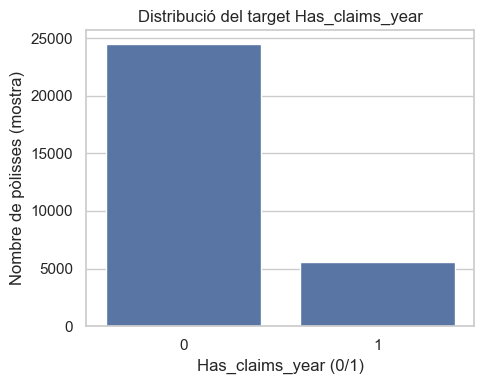


Desequilibri (0/1): 4.37 : 1

--- Taxa de sinistre per Type_risk ---


,claim_rate,count
Type_risk,,
2,0.228050,13212
3,0.192650,82990
1,0.075747,8502
4,0.001175,851


Figura desada a: eda/figures\freq_claimrate_Type_risk.png


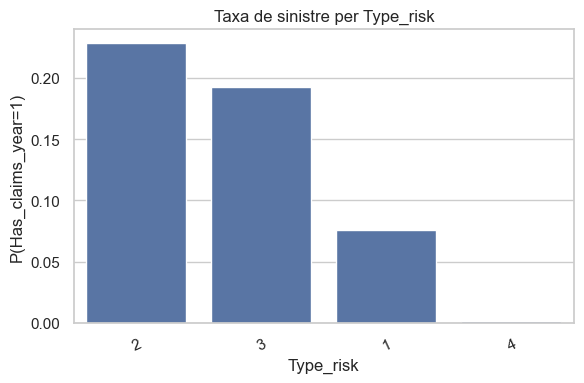


--- Taxa de sinistre per Area ---


,claim_rate,count
Area,,
1,0.204248,28911
0,0.179283,76644


Figura desada a: eda/figures\freq_claimrate_Area.png


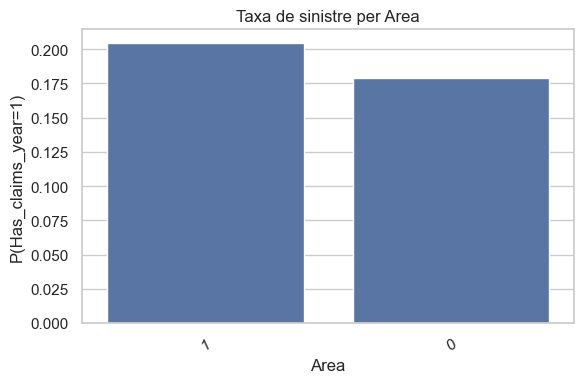


--- Taxa de sinistre per Type_fuel ---


,claim_rate,count
Type_fuel,,
D,0.208468,64998
P,0.153352,38793
Unknown,0.083333,1764


Figura desada a: eda/figures\freq_claimrate_Type_fuel.png


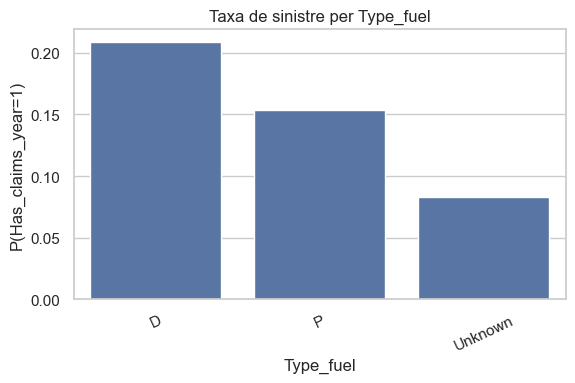


--- Taxa de sinistre per Distribution_channel ---


,claim_rate,count
Distribution_channel,,
1,0.203010,47638
0,0.172229,57917


Figura desada a: eda/figures\freq_claimrate_Distribution_channel.png


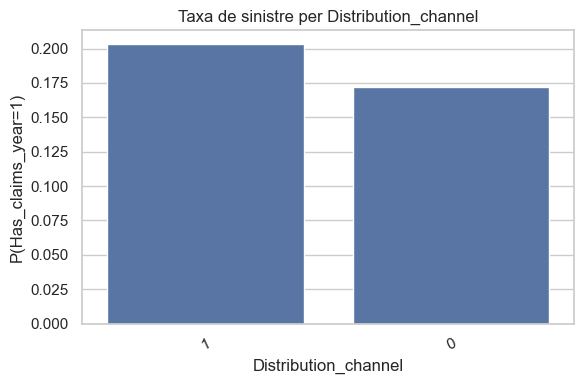


--- Taxa de sinistre per Has_lapse ---


,claim_rate,count
Has_lapse,,
1,0.219364,35147
0,0.169526,70408


Figura desada a: eda/figures\freq_claimrate_Has_lapse.png


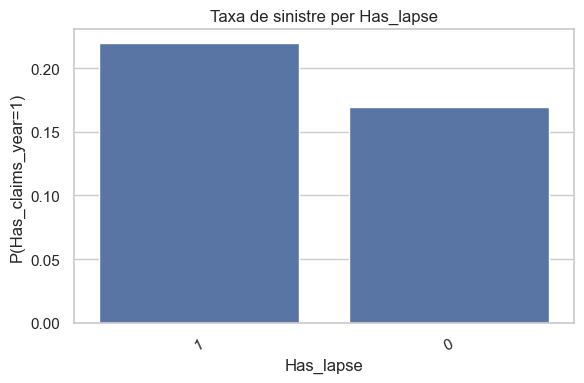


--- Taxa de sinistre per Second_driver ---


,claim_rate,count
Second_driver,,
1,0.227217,13058
0,0.180319,92497


Figura desada a: eda/figures\freq_claimrate_Second_driver.png


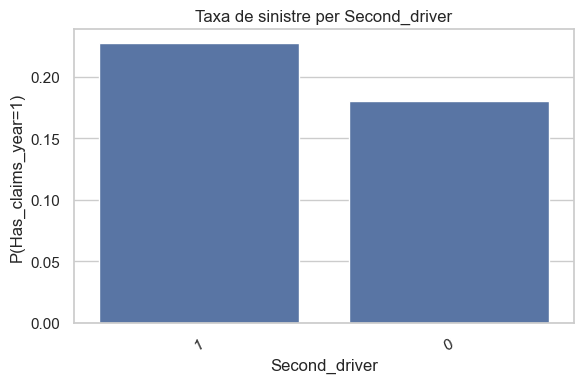

Figura desada a: eda/figures\freq_box_Driver_age.png


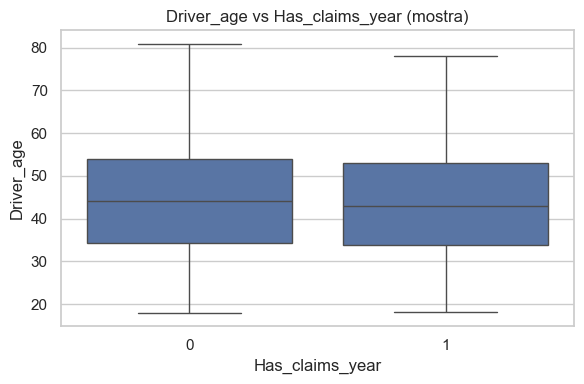

Figura desada a: eda/figures\freq_box_Vehicle_age.png


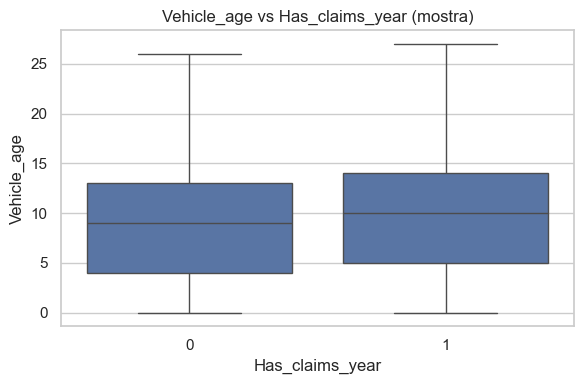

Figura desada a: eda/figures\freq_box_Power.png


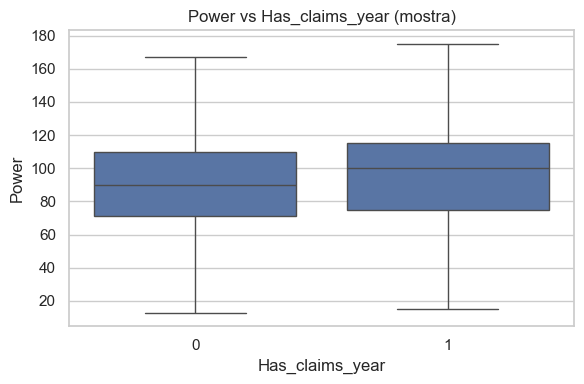

Figura desada a: eda/figures\freq_box_Premium.png


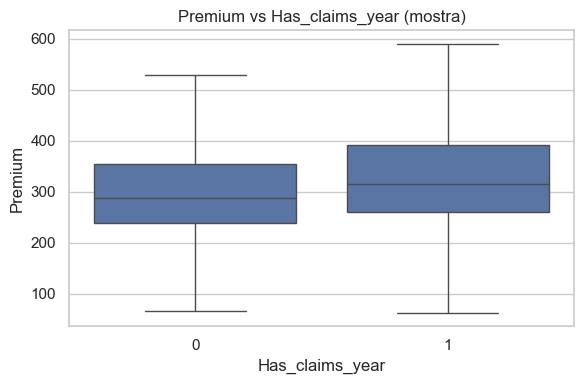

Figura desada a: eda/figures\freq_box_Value_vehicle.png


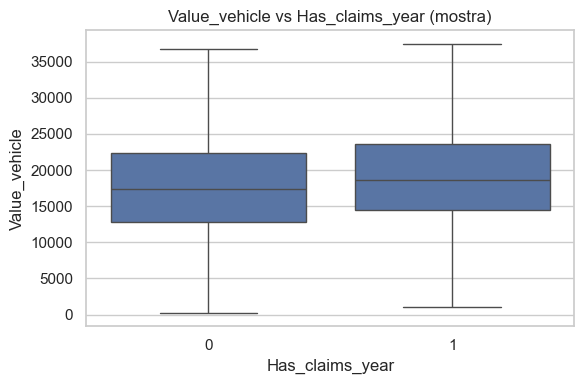


--- Top correlacions point-biserial (predictors ex ante) ---


,variable,r_pointbiserial,p_value,n_used,abs_r
28,R_Claims_history,0.575965,0.000000e+00,105555,0.575965
29,Has_claims_history,0.348369,0.000000e+00,105555,0.348369
27,N_claims_history,0.289861,0.000000e+00,105555,0.289861
3,Policy_age,-0.136041,0.000000e+00,105555,0.136041
30,Payment,0.116151,9.971082e-314,105555,0.116151
26,Premium,0.105799,2.287284e-260,105555,0.105799
4,Days_to_next,0.092077,1.868021e-197,105555,0.092077
20,Policies_in_force,0.092033,2.876047e-197,105555,0.092033
10,Length_missing_flag,-0.088024,1.450795e-180,105555,0.088024
16,Length,0.086874,6.475508e-176,105555,0.086874


Figura desada a: eda/figures\freq_pointbiserial_corr.png


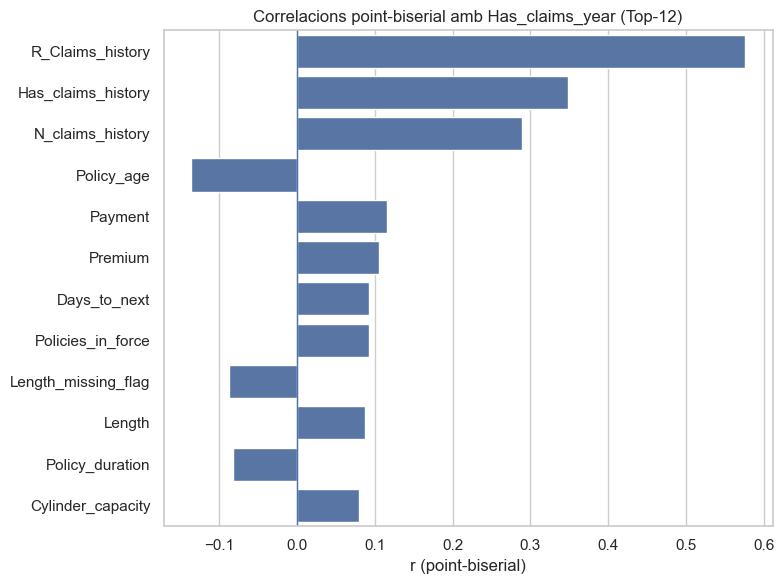


3.3.3.3 completat. Revisa 'eda/figures' per a les figures generades.


In [9]:
# ============================================================
# 3.3.3.3 ANÀLISI DE FREQÜÈNCIA (target: Has_claims_year)
# ============================================================
# Objectius (EDA específica de freqüència):
#   1) Descriure la distribució del target binari Has_claims_year i el desequilibri de classes.
#   2) Estimar la taxa de sinistre per factors categòrics (segments de cartera).
#   3) Visualitzar diferències en variables numèriques clau segons Has_claims_year.
#   4) Quantificar associacions preliminars entre predictors continus i el target mitjançant
#      correlació point-biserial (adequada per binària vs contínua).
#
# NOTES METODOLÒGIQUES (observació del tutor / evitar leakage):
#   - En freqüència, NO vull utilitzar variables ex post derivades de sinistres/cost de l’any actual.
#     Exemples típics a EXCLOURE del diagnòstic de predictors: N_claims_year, Cost_claims_year,
#     Claims_to_premium_ratio (i també variables tècniques de split com Policy_year).
#   - En aquesta secció, aquestes variables es poden mirar com a diagnòstic global si em fa falta,
#     però NO les incloc com a predictors numèrics per a correlacions/relacions.
#
# NOTES DE RENDIMENT:
#   - Per a figures, faig un MOSTREIG (p. ex. 30.000 files).
#     Les taules (taxes) les calculo sobre tot `df` per tenir estimacions més estables.
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

# Configuro la sortida perquè a l'EDA es vegi bé i sigui consistent
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")

# M'asseguro que tinc la carpeta per guardar figures
os.makedirs("eda/figures", exist_ok=True)

def savefig_freq(filename, dpi=150):
    """Funció auxiliar per desar figures de freqüència de manera consistent."""
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")

# ------------------------------------------------------------
# 0) PARÀMETRES I PREPARACIÓ
# ------------------------------------------------------------
# Deixo definits els noms dels targets per no repetir strings i evitar errors.
target = "Has_claims_year"
target_sev = "Cost_claims_year"  # aquí no l'uso com a predictor (només el tinc present)

print("Inici 3.3.3.3 - Freqüència")
print("Dimensions:", df.shape)

# MOSTREIG per a GRÀFICS (acceleració)
# Per a gràfics, una mostra gran ja em dona patrons i em va molt més ràpid.
N_PLOT = 30000
df_plot = df.sample(min(N_PLOT, len(df)), random_state=42).copy()

# Variables a EXCLOURE explícitament com a predictors de freqüència (leakage / ex post / tècniques)
# Les deixo ben clares perquè després no se m'hi coli res per error.
leakage_vars = {
    "N_claims_year",              # deriva directament del target anual
    "Cost_claims_year",           # severitat anual (ex post)
    "Claims_to_premium_ratio",    # ràtio ex post (usa cost anual)
    "Policy_year",                # variable tècnica per split temporal
    "set_type"                    # etiqueta train/test (si existeix)
}

# Agafo totes les numèriques detectades inicialment
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

# Em garanteixo que les columnes numèriques segueixen sent numèriques.
# (La conversió "forta" d'object a numèric ja l'he d'haver feta al 3.3.3.1.)
for c in num_cols_all:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Recalculo llista numèrica després de la conversió
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()

# Predictors numèrics per a freq (excloc ID, targets i leakage_vars)
num_cols = [
    c for c in num_cols_all
    if c not in {"ID", target, target_sev} and c not in leakage_vars
]

# Factors categòrics que vull analitzar per segmentar taxes (només si existeixen)
cat_factors = [
    c for c in ["Type_risk", "Area", "Type_fuel", "Distribution_channel", "Has_lapse", "Second_driver"]
    if c in df.columns
]

# ------------------------------------------------------------
# 1) DISTRIBUCIÓ DEL TARGET I DESEQUILIBRI
# ------------------------------------------------------------
# Primer miro quants 0 i 1 tinc, i quin percentatge representen.
print("\n--- Distribució Has_claims_year ---")
target_counts = df[target].value_counts(dropna=False)
target_pct = (target_counts / len(df) * 100).round(2)
display(pd.DataFrame({"count": target_counts, "pct": target_pct}))

# Figura sobre mostra (mateixa lectura i més ràpida)
plt.figure(figsize=(5, 4))
sns.countplot(data=df_plot, x=target, order=target_counts.index)
plt.title("Distribució del target Has_claims_year")
plt.xlabel("Has_claims_year (0/1)")
plt.ylabel("Nombre de pòlisses (mostra)")
savefig_freq("freq_target_distribution.png")
plt.show()
plt.close()

# Calculo un desequilibri simple 0/1 (per tenir una idea del nivell d'imbalance)
imbalance_ratio = target_counts.get(0, np.nan) / max(target_counts.get(1, 1), 1)
print(f"\nDesequilibri (0/1): {imbalance_ratio:.2f} : 1")

# ------------------------------------------------------------
# 2) TAXA DE SINISTRE PER VARIABLES CATEGÒRIQUES
# ------------------------------------------------------------
# Aquí calculo P(Has_claims_year=1) per categoria i ho acompaño del volum de casos
# per no interpretar taxes d'un segment amb 4 registres com si fos robust.
def claim_rate_by_factor(col: str) -> pd.DataFrame:
    """
    Retorna una taula amb:
      - claim_rate: P(Has_claims_year=1) per categoria
      - count: nombre d'observacions per categoria
    Calculat sobre TOT df per tenir estimacions més estables.
    """
    tab = df.groupby(col)[target].mean().rename("claim_rate").to_frame()
    tab["count"] = df[col].value_counts()
    return tab.sort_values("claim_rate", ascending=False)

for col in cat_factors:
    print(f"\n--- Taxa de sinistre per {col} ---")
    tab = claim_rate_by_factor(col)
    display(tab)

    # Barplot sobre la taula agregada (això és ràpid i no depèn de la mida del dataset)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=tab.reset_index(), x=col, y="claim_rate", order=tab.index)
    plt.title(f"Taxa de sinistre per {col}")
    plt.ylabel("P(Has_claims_year=1)")
    plt.xlabel(col)
    plt.xticks(rotation=25)
    savefig_freq(f"freq_claimrate_{col}.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 3) BOXPLOTS DE VARIABLES NUMÈRIQUES vs TARGET (mínims)
# ------------------------------------------------------------
# Aquí comparo distribucions de variables numèriques clau segons Has_claims_year.
# Ho faig sobre mostra per rendiment i, per robustesa, converteixo a numèric dins la mateixa rutina.
box_vars_required = [v for v in ["Driver_age", "Vehicle_age", "Power", "Premium", "Value_vehicle"] if v in df.columns]

for v in box_vars_required:
    # Preparo sèrie numèrica robusta sobre df_plot (gestionant punts/coma si mai ve com text)
    s = df_plot[v].replace([np.inf, -np.inf], np.nan)
    if s.dtype == "object":
        s = s.astype(str).str.replace(",", ".", regex=False)
    df_plot[v + "__num"] = pd.to_numeric(s, errors="coerce")

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_plot, x=target, y=v + "__num", showfliers=False)
    plt.title(f"{v} vs Has_claims_year (mostra)")
    plt.xlabel("Has_claims_year")
    plt.ylabel(v)
    savefig_freq(f"freq_box_{v}.png")
    plt.show()
    plt.close()

# Netejo les columnes auxiliars que he creat per no embrutar df_plot
aux_cols = [c for c in df_plot.columns if c.endswith("__num")]
df_plot.drop(columns=aux_cols, inplace=True, errors="ignore")

# ------------------------------------------------------------
# 4) CORRELACIÓ POINT-BISERIAL (binària vs contínua)
# ------------------------------------------------------------
# Aquesta correlació em dona una mesura d'associació lineal entre:
#   - un target binari (Has_claims_year)
#   - i un predictor continu
# Ho faig només amb predictors ex ante (num_cols) i sobre tot df.
pb_rows = []
for v in num_cols:
    s = df[[v, target]].replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty or s[v].nunique() <= 1:
        continue
    r, p = pointbiserialr(s[target], s[v])
    pb_rows.append([v, r, p, len(s)])

pb_df = pd.DataFrame(pb_rows, columns=["variable", "r_pointbiserial", "p_value", "n_used"])
pb_df["abs_r"] = pb_df["r_pointbiserial"].abs()
pb_df = pb_df.sort_values("abs_r", ascending=False)

print("\n--- Top correlacions point-biserial (predictors ex ante) ---")
display(pb_df.head(15))

# Figura amb top-12 correlacions perquè sigui fàcil de llegir
topk = pb_df.head(12).copy()
plt.figure(figsize=(8, 6))
sns.barplot(data=topk, y="variable", x="r_pointbiserial")
plt.axvline(0, lw=1)
plt.title("Correlacions point-biserial amb Has_claims_year (Top-12)")
plt.xlabel("r (point-biserial)")
plt.ylabel("")
savefig_freq("freq_pointbiserial_corr.png")
plt.show()
plt.close()

print("\n3.3.3.3 completat. Revisa 'eda/figures' per a les figures generades.")


#### <b>3.3.3.4 Anàlisi de severitat (target: Cost_claims_year, filtre Has_claims_year = 1)</b>

Inici 3.3.3.4 — Anàlisi de severitat
Dimensions dataset complet: (105555, 46)

Registres amb sinistre anual i cost > 0: 19646
Percentatge sobre el total: 18.61 %

--- Estadístiques descriptives Cost_claims_year (sinistres) ---


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Cost_claims_year,19646.0,825.040281,3342.045365,40.05,49.95,51.95,95.77,289.435,882.0,2861.9425,8301.5415,260853.24


Figura desada a: eda/figures\sev_dist_Cost_claims_year.png


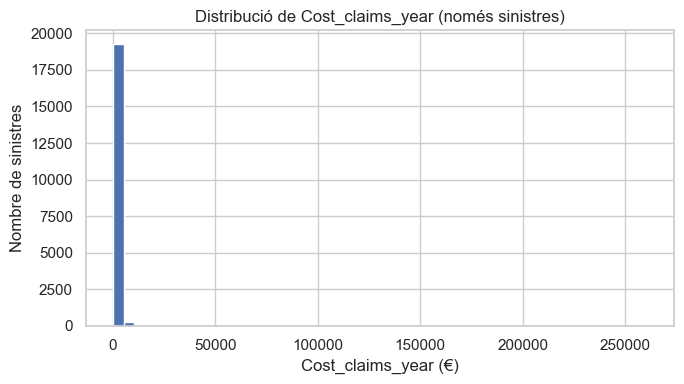

Figura desada a: eda/figures\sev_box_Cost_claims_year.png


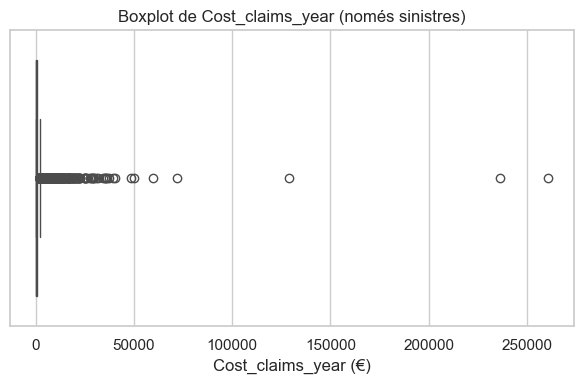

Figura desada a: eda/figures\sev_dist_log_Cost_claims_year.png


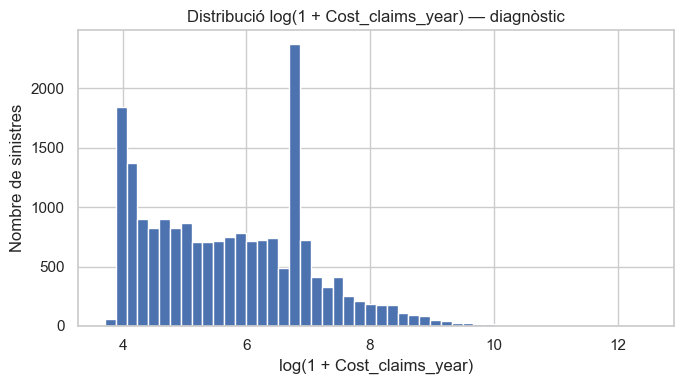


Asimetria (skewness): 47.214
Curtosi (kurtosis): 3258.274

--- Severitat per segments categòrics (taules) ---

Type_risk


,mean,median,p90,count
Type_risk,,,,
3,857.001447,298.415,1637.118,15988
2,729.423604,282.320,1423.380,3013
1,479.900994,141.255,969.602,644
4,192.670000,192.670,192.670,1



Area


,mean,median,p90,count
Area,,,,
1,846.083041,292.29,1734.554,5905
0,815.997454,287.50,1512.000,13741



Type_fuel


,mean,median,p90,count
Type_fuel,,,,
D,829.501027,303.11,1626.719,13550
P,825.316645,262.06,1491.170,5949
Unknown,402.678503,128.99,905.690,147



Distribution_channel


,mean,median,p90,count
Distribution_channel,,,,
1,868.956739,300.22,1738.560,9671
0,782.462231,278.23,1442.338,9975



3.3.3.4 completat. Revisa 'eda/figures' per a les figures generades.


In [11]:
# ============================================================
# 3.3.3.4 ANÀLISI DE SEVERITAT
# Target: Cost_claims_year | Has_claims_year = 1
# ============================================================
# Objectius:
#   - Caracteritzar la distribució del cost del sinistre (severitat)
#   - Confirmar asimetria, cues llargues i presència d’outliers
#   - Explorar diferències descriptives per segments de cartera
#   - Analitzar relacions preliminars amb predictors ex ante
#
# Notes metodològiques:
#   * Aquí només analitzo pòlisses amb sinistre (Has_claims_year = 1)
#   * El log(1 + cost) el faig servir NOMÉS com a diagnòstic visual
#   * No elimino cap outlier (coherent amb pràctica actuarial i amb l’objectiu descriptiu)
#   * És una EDA exploratòria, no inferencial
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuro visualització per tenir figures consistents
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")

# Creo (si no existeix) la carpeta on guardaré figures de severitat
os.makedirs("eda/figures", exist_ok=True)

def savefig_sev(filename, dpi=150):
    """
    Funció auxiliar per desar figures de l’anàlisi de severitat
    dins la carpeta eda/figures.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")

# Variables objectiu (targets)
target_freq = "Has_claims_year"
target_sev  = "Cost_claims_year"

print("Inici 3.3.3.4 — Anàlisi de severitat")
print("Dimensions dataset complet:", df.shape)

# ------------------------------------------------------------
# 0) FILTRE DE SEVERITAT
# ------------------------------------------------------------
# Per analitzar severitat, em quedo només amb:
#   - registres amb sinistre anual (Has_claims_year = 1)
#   - i cost estrictament positiu (evito zeros o valors no informatius)
sev_df = df[(df[target_freq] == 1) & (df[target_sev] > 0)].copy()

print("\nRegistres amb sinistre anual i cost > 0:", sev_df.shape[0])
print(
    "Percentatge sobre el total:",
    round(sev_df.shape[0] / df.shape[0] * 100, 2), "%"
)

# ------------------------------------------------------------
# 1) DISTRIBUCIÓ DEL COST DEL SINISTRE
# ------------------------------------------------------------
# Faig descriptives amb percentils extrems perquè la severitat normalment
# té cues llargues i els percentils alts són molt informatius.
sev_summary = sev_df[target_sev].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
)

print("\n--- Estadístiques descriptives Cost_claims_year (sinistres) ---")
display(sev_summary.to_frame().T)

# Histograma del cost (escala original)
# Aquí és normal que surti molt concentrat a la part baixa i amb cua a la dreta.
plt.figure(figsize=(7, 4))
plt.hist(sev_df[target_sev], bins=50)
plt.title("Distribució de Cost_claims_year (només sinistres)")
plt.xlabel("Cost_claims_year (€)")
plt.ylabel("Nombre de sinistres")
savefig_sev("sev_dist_Cost_claims_year.png")
plt.show()
plt.close()

# Boxplot del cost (sense eliminar outliers)
# El boxplot em va bé per veure ràpidament dispersió i valors extrems.
plt.figure(figsize=(6, 4))
sns.boxplot(x=sev_df[target_sev], orient="h")
plt.title("Boxplot de Cost_claims_year (només sinistres)")
plt.xlabel("Cost_claims_year (€)")
savefig_sev("sev_box_Cost_claims_year.png")
plt.show()
plt.close()

# Transformació logarítmica només per diagnòstic
# La faig servir per "comprimir" la cua i veure millor la forma general.
sev_log = np.log1p(sev_df[target_sev])

plt.figure(figsize=(7, 4))
plt.hist(sev_log, bins=50)
plt.title("Distribució log(1 + Cost_claims_year) — diagnòstic")
plt.xlabel("log(1 + Cost_claims_year)")
plt.ylabel("Nombre de sinistres")
savefig_sev("sev_dist_log_Cost_claims_year.png")
plt.show()
plt.close()

# Mesures de forma
# Espero asimetria positiva i curtosi elevada (cua llarga), típic en severitat.
print("\nAsimetria (skewness):", round(sev_df[target_sev].skew(), 3))
print("Curtosi (kurtosis):", round(sev_df[target_sev].kurtosis(), 3))

# =============================================================
# 2) SEVERITAT PER SEGMENTS (TAULES, NO GRÀFICS)
# =============================================================
# Aquí segmentaré la severitat per variables categòriques rellevants,
# i miraré mitjana, mediana i percentil 90, sempre amb el volum (count)
# per no interpretar segments amb poca mostra.
cat_factors = [
    c for c in ["Type_risk", "Area", "Type_fuel", "Distribution_channel"]
    if c in sev_df.columns
]

print("\n--- Severitat per segments categòrics (taules) ---")
for col in cat_factors:
    tab = (
        sev_df
        .groupby(col)[target_sev]
        .agg(
            mean="mean",
            median="median",
            p90=lambda x: x.quantile(0.9),
            count="size"
        )
        .sort_values("mean", ascending=False)
    )
    print(f"\n{col}")
    display(tab)

print("\n3.3.3.4 completat. Revisa 'eda/figures' per a les figures generades.")


#### <b>3.3.3.5 Anàlisi temporal</b>

Inici 3.3.3.5 — Anàlisi temporal
Dimensions dataset: (105555, 46)

--- Tendència anual de la freqüència ---


,claim_rate,n_policies
Policy_year,,
2015,0.299846,4559
2016,0.282805,31428
2017,0.177880,33753
2018,0.094569,35815


Figura desada a: eda/figures\temp_trend_frequency.png


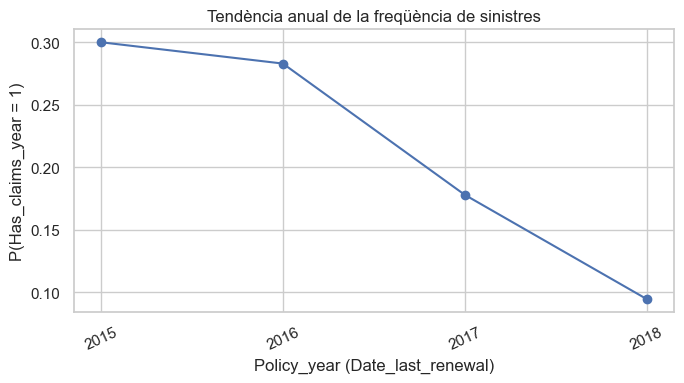


--- Tendència anual de la severitat (només sinistres) ---


,mean_sev,median_sev,n_sinistres
Policy_year,,,
2015,872.688274,340.070,1367
2016,871.913203,306.395,8888
2017,824.113188,289.080,6004
2018,684.451246,226.010,3387


Figura desada a: eda/figures\temp_trend_severity.png


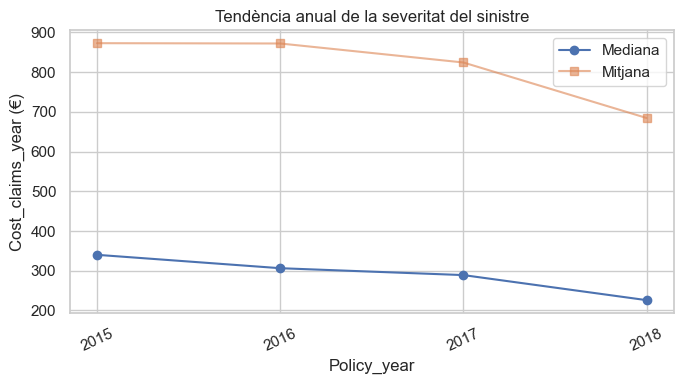


--- Tendència anual de la prima ---


,mean_premium,median_premium
Policy_year,,
2015,315.770173,290.530
2016,318.451657,296.125
2017,317.952406,293.240
2018,311.721246,287.930


Figura desada a: eda/figures\temp_trend_premium.png


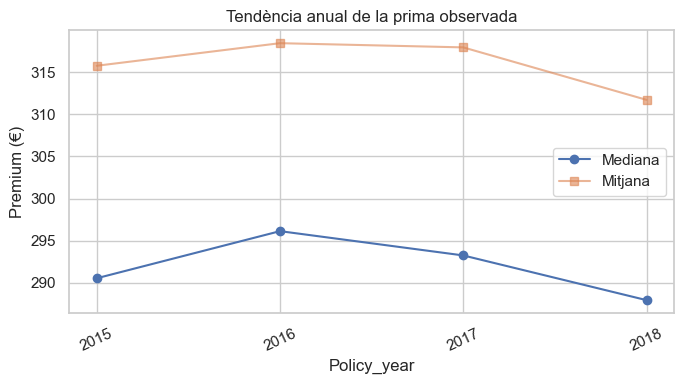


--- Comparació train (2015–2017) vs test (2018) ---


,mean_train,mean_test,rel_change_%
Has_claims_year,0.094569,0.233137,146.53
Vehicle_age,10.047997,8.832449,-12.10
Value_vehicle,18712.395504,18260.240111,-2.42
Driver_age,45.047099,43.983305,-2.36
Premium,311.721246,318.034735,2.03
Power,93.205696,92.413980,-0.85


Figura desada a: eda/figures\temp_train_test_drift.png


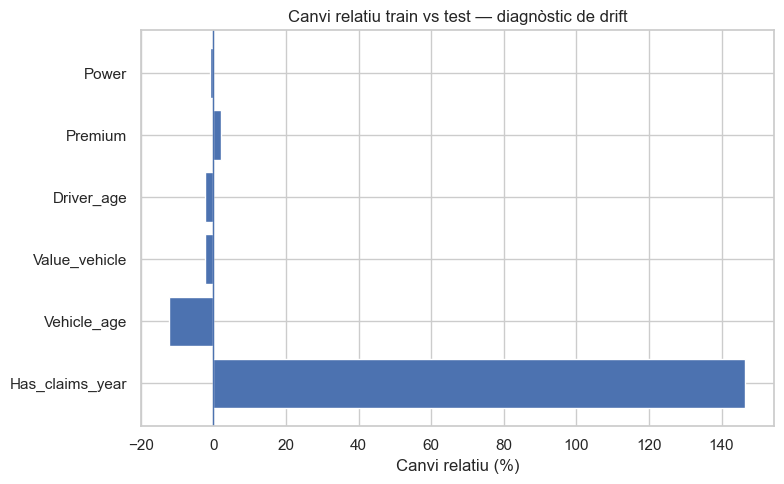


3.3.3.5 completat.


In [13]:
# ============================================================
# 3.3.3.5 ANÀLISI TEMPORAL
# Coherent amb split temporal 2015–2017 (train) vs 2018 (test)
# ============================================================
# En aquest apartat faig una anàlisi temporal per assegurar-me que:
#   - les tendències anuals tenen sentit
#   - no hi ha canvis bruscos inesperats entre anys
#   - el split train/test és coherent i no introdueix drift greu
#
# És una anàlisi purament descriptiva i de diagnòstic, no inferencial.
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració de visualització per tenir taules i figures clares
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")

# Creo (si no existeix) la carpeta on desaré les figures temporals
os.makedirs("eda/figures", exist_ok=True)

def savefig_temp(filename, dpi=150):
    """
    Funció auxiliar per desar figures de l’anàlisi temporal
    dins la carpeta eda/figures amb un format homogeni.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")

print("Inici 3.3.3.5 — Anàlisi temporal")
print("Dimensions dataset:", df.shape)

# ------------------------------------------------------------
# 0) VALIDACIONS PRÈVIES
# ------------------------------------------------------------
# Aquí verifico que les variables temporals necessàries
# (creades explícitament al punt 3.3.3.1) existeixin.
required_cols = ["Policy_year", "set_type"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Falten columnes requerides: {missing}. Executa abans 3.3.3.1.")

# Defineixo els noms de variables clau per no repetir strings
target_freq = "Has_claims_year"
target_sev  = "Cost_claims_year"
premium_col = "Premium"
ratio_col   = "Claims_to_premium_ratio"

# Conversions suaus a numèric només per facilitar l'EDA
# (no estic modificant el dataset de fons del pipeline)
for c in [target_freq, target_sev, premium_col, ratio_col]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ------------------------------------------------------------
# 1) TENDÈNCIA ANUAL DE FREQÜÈNCIA
# ------------------------------------------------------------
# Aquí miro com evoluciona la probabilitat de sinistre
# (P(Has_claims_year = 1)) al llarg dels anys.
freq_year = (
    df.groupby("Policy_year")[target_freq]
      .agg(claim_rate="mean", n_policies="size")
      .sort_index()
)

print("\n--- Tendència anual de la freqüència ---")
display(freq_year)

plt.figure(figsize=(7, 4))
plt.plot(freq_year.index.astype(str), freq_year["claim_rate"], marker="o")
plt.title("Tendència anual de la freqüència de sinistres")
plt.xlabel("Policy_year (Date_last_renewal)")
plt.ylabel("P(Has_claims_year = 1)")
plt.xticks(rotation=25)
savefig_temp("temp_trend_frequency.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 2) TENDÈNCIA ANUAL DE SEVERITAT (només sinistres)
# ------------------------------------------------------------
# Per a la severitat, només considero registres amb sinistre
# i cost estrictament positiu.
sev_df = df[(df[target_freq] == 1) & (df[target_sev] > 0)].copy()

sev_year = (
    sev_df.groupby("Policy_year")[target_sev]
          .agg(mean_sev="mean", median_sev="median", n_sinistres="size")
          .sort_index()
)

print("\n--- Tendència anual de la severitat (només sinistres) ---")
display(sev_year)

plt.figure(figsize=(7, 4))
plt.plot(sev_year.index.astype(str), sev_year["median_sev"], marker="o", label="Mediana")
plt.plot(sev_year.index.astype(str), sev_year["mean_sev"], marker="s", alpha=0.6, label="Mitjana")
plt.title("Tendència anual de la severitat del sinistre")
plt.xlabel("Policy_year")
plt.ylabel("Cost_claims_year (€)")
plt.legend()
plt.xticks(rotation=25)
savefig_temp("temp_trend_severity.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 3) TENDÈNCIA DE LA PRIMA (diagnòstic de coherència)
# ------------------------------------------------------------
# Aquí reviso si la prima mitjana/mediana també mostra
# una evolució coherent al llarg del temps.
premium_year = (
    df.groupby("Policy_year")[premium_col]
      .agg(mean_premium="mean", median_premium="median")
      .sort_index()
)

print("\n--- Tendència anual de la prima ---")
display(premium_year)

plt.figure(figsize=(7, 4))
plt.plot(premium_year.index.astype(str), premium_year["median_premium"], marker="o", label="Mediana")
plt.plot(premium_year.index.astype(str), premium_year["mean_premium"], marker="s", alpha=0.6, label="Mitjana")
plt.title("Tendència anual de la prima observada")
plt.xlabel("Policy_year")
plt.ylabel("Premium (€)")
plt.legend()
plt.xticks(rotation=25)
savefig_temp("temp_trend_premium.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 4) COMPARACIÓ TRAIN vs TEST (diagnòstic de drift simple)
# ------------------------------------------------------------
# Comparo mitjanes de variables clau entre:
#   - train: 2015–2017
#   - test: 2018
# per detectar possibles canvis estructurals rellevants.
print("\n--- Comparació train (2015–2017) vs test (2018) ---")

drift_vars = [
    target_freq,
    premium_col,
    "Driver_age",
    "Vehicle_age",
    "Power",
    "Value_vehicle"
]
drift_vars = [v for v in drift_vars if v in df.columns]

drift_table = (
    df.groupby("set_type")[drift_vars]
      .mean(numeric_only=True)
      .T
)

drift_table.columns = ["mean_train", "mean_test"]
drift_table["rel_change_%"] = (
    (drift_table["mean_test"] / drift_table["mean_train"] - 1) * 100
).round(2)

display(drift_table.sort_values("rel_change_%", key=lambda x: x.abs(), ascending=False))

# Gràfic amb les variables amb més canvi relatiu
plt.figure(figsize=(8, 5))
top_drift = drift_table.copy()
top_drift["abs_change"] = top_drift["rel_change_%"].abs()
top_drift = top_drift.sort_values("abs_change", ascending=False).head(8)

plt.barh(top_drift.index, top_drift["rel_change_%"])
plt.axvline(0, lw=1)
plt.title("Canvi relatiu train vs test — diagnòstic de drift")
plt.xlabel("Canvi relatiu (%)")
plt.ylabel("")
savefig_temp("temp_train_test_drift.png")
plt.show()
plt.close()

print("\n3.3.3.5 completat.")
